In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces 
import warnings
warnings.filterwarnings("ignore") 

# Environment Setup

In [2]:
class UAV_env(gym.Env):
    
    def __init__(self, action='box', terminate=False, render_mode=None): # action = 'box' for continuous action space, 'discrete' for discrete action space
        super(UAV_env, self).__init__()

        # UAV parameters
        self.m = 1.56  # Mass (kg)
        self.Jyy = 0.0576  # Moment of inertia (kg-m^2)
        self.CL = lambda a: (3.5*a) + 0.09  # Lift coefficient
        self.CD = lambda a: (0.2*a) + 0.016  # Drag coefficient
        self.CLdelta = 0.27  # Lift coefficient derivative
        self.Cm0 = -0.02  # Pitching moment coefficient at zero angle of attack
        self.Cmalpha = -0.57  # Pitching moment coefficient derivative
        self.Cmq = -1.4  # Pitching moment coefficient derivative
        self.Cmdelta = -0.32  # Pitching moment coefficient derivative

        # State and control constraints
        self.T_min = 0
        self.T_max = 4
        self.delta_min = -0.4363
        self.delta_max = 0.1745
        self.Va_min = 5
        self.Va_max = 15
        self.alpha_min = 0
        self.alpha_max = 0.2618

        # Simulation time
        # self.dt = 0.02  # Sampling time (seconds)
        self.dt = 1e-3  # For NaN Problem
        self.t_final = 10  # Final time (seconds)
        self.t = 0  # Initial time

        # Initial state
        self.X0 = np.array([9.96, 0.87, 0, 0.0873, 50])  # [u, w, q, theta, h]
        self.U0 = np.array([1.0545, -0.2179])  # [T, delta]

        # Desired final state
        self.Xd = np.array([9.85, 1.74, 0, 0.1745, 62])

        # Discrete action space list
        self.Ud = [[self.T_min, self.delta_min], [self.T_min, self.delta_max], [self.T_max, self.delta_min], [self.T_max, self.delta_max]]

        # Define action and observation spaces

        self.action = action    

        if self.action == 'box':
            self.action_space = spaces.Box(low=np.array([self.T_min, self.delta_min]), high=np.array([self.T_max, self.delta_max]), dtype=np.float64) # Continuous action space
            self.transform = lambda a: a

        elif self.action == 'discrete':
            self.action_space = spaces.Discrete(len(self.Ud)) # Discrete action space
            self.transform = lambda a: self.Ud[a] if self.t > 0 else self.U0
        
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(5,), dtype=np.float64)

        self.state = None
        self.penalty = -100
        self.terminate = terminate

    def dynamics(self, X, U):
        u, w, q, theta, h = X       # States
        T, delta = U                # Controls

        Va = np.sqrt(u**2 + w**2)   # Airspeed (need to check this to keep within constraints)
        alpha = np.arctan(w / u)    # Angle of attack (need to check this to keep within constraints)

        CL = self.CL(alpha)         # Lift coefficient
        CD = self.CD(alpha)         # Drag coefficient

        udot = (-q*w) + (0.5*Va**2/self.m) * (CL*np.sin(alpha) - CD*np.cos(alpha) + self.CLdelta*np.sin(alpha)*delta) - (9.81*np.sin(theta)) + (T/self.m)
        wdot = (q*u) + (0.5*Va**2/self.m) * (-CL*np.cos(alpha) - CD*np.sin(alpha) - self.CLdelta*np.cos(alpha)*delta) + (9.81*np.cos(theta))
        qdot = (0.5*Va**2/self.Jyy) * (self.Cm0 + self.Cmalpha*alpha + (0.25*self.Cmq*q/Va) + self.Cmdelta*delta)
        thetadot = q
        hdot = (-u*np.sin(theta)) + (w*np.cos(theta))

        return np.array([udot, wdot, qdot, thetadot, hdot]) # Return state derivatives
    
    def cost(self, done=False):
        w_prox = self.t
        proximity_cost = w_prox * np.linalg.norm(self.state - self.Xd) # Proximity cost

        u, w, _, _, _ = self.state
        Va = np.sqrt(u**2 + w**2)
        alpha = np.arctan(w / u)
        V_mid = (self.Va_min + self.Va_max) / 2
        alpha_mid = (self.alpha_min + self.alpha_max) / 2

        if Va < self.Va_min or Va > self.Va_max or alpha < self.alpha_min or alpha > self.alpha_max:
            w_bounds = -self.penalty/self.t
            if self.terminate:
                done = True
        else:
            w_bounds = self.dt/self.t
        bounds_cost = w_bounds * (np.linalg.norm([Va - V_mid, alpha - alpha_mid]))

        reward = -(proximity_cost + bounds_cost) # Total cost
        info = {'Va': Va, 'alpha': alpha}

        if self.t >= self.t_final:
            done = True
            if np.linalg.norm(self.state - self.Xd) < 1:
                reward += self.penalty**2

        return reward, done, info


    def step(self, action):
        action = self.transform(action) # Transform discrete action
        self.state = self.integrate(self.state, action) 
        reward, done, info = self.cost()
        return self.state, reward, done, False, info

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = np.copy(self.X0)
        self.t = 0
        info = {}
        return self.state, info

    def integrate(self, X, U):
        X_dot = self.dynamics(X, U)
        X += self.dt * X_dot
        self.t += self.dt
        return X

In [3]:
def plot(env, state, action, info, reward, time, episode):
    
    u, w, q, theta, h = np.array(state).T
    T, delta = np.array(action).T
    Va, alpha = np.array(info).T
    R = np.array(reward)
    t = np.array(time)
    Xd = env.Xd
    X0 = env.X0
    u0, w0, q0, theta0, h0 = X0
    ud, wd, qd, thetad, hd = Xd
    Tmin, Tmax = env.T_min, env.T_max
    deltamin, deltamax = env.delta_min, env.delta_max
    Vmin, Vmax = env.Va_min, env.Va_max
    alphamin, alphamax = env.alpha_min, env.alpha_max

    plt.figure(figsize=(40, 4))
    plt.subplot(1, 5, 1)
    plt.plot(t, u)
    plt.plot(t, u0*np.ones_like(t), '--', label='u_0')
    plt.plot(t, ud*np.ones_like(t), '--', label='u_d')
    plt.xlabel('t')
    plt.ylabel('u')
    plt.legend(loc='upper right')
    plt.suptitle('Episode:{} State'.format(episode+1))
    plt.subplot(1, 5, 2)
    plt.plot(t, w)
    plt.plot(t, w0*np.ones_like(t), '--', label='w_0')
    plt.plot(t, wd*np.ones_like(t), '--', label='w_d')
    plt.xlabel('t')
    plt.ylabel('w')
    plt.legend(loc='upper right')
    plt.subplot(1, 5, 3)
    plt.plot(t, q)
    plt.plot(t, q0*np.ones_like(t), '--', label='q_0')
    plt.plot(t, qd*np.ones_like(t), '--', label='q_d')
    plt.xlabel('t')
    plt.ylabel('q')
    plt.legend(loc='upper right')
    plt.subplot(1, 5, 4)
    plt.plot(t, theta)
    plt.plot(t, theta0*np.ones_like(t), '--', label='theta_0')
    plt.plot(t, thetad*np.ones_like(t), '--', label='theta_d')
    plt.xlabel('t')
    plt.ylabel('theta')
    plt.legend(loc='upper right')
    plt.subplot(1, 5, 5)
    plt.plot(t, h)
    plt.plot(t, h0*np.ones_like(t), '--', label='h_0')
    plt.plot(t, hd*np.ones_like(t), '--', label='h_d')
    plt.xlabel('t')
    plt.ylabel('h')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(40, 4))
    plt.subplot(1, 5, 1)
    plt.plot(t, T)
    plt.plot(t, Tmin*np.ones_like(t), '--', label='T_min')
    plt.plot(t, Tmax*np.ones_like(t), '--', label='T_max')
    plt.xlabel('t')
    plt.ylabel('T')
    plt.legend(loc='upper right')
    plt.subplot(1, 5, 2)
    plt.plot(t, delta)
    plt.plot(t, deltamin*np.ones_like(t), '--', label='delta_min')
    plt.plot(t, deltamax*np.ones_like(t), '--', label='delta_max')
    plt.xlabel('t')
    plt.ylabel('delta')
    plt.legend(loc='upper right')
    plt.subplot(1, 5, 3)
    plt.plot(t, Va)
    plt.plot(t, Vmin*np.ones_like(t), '--', label='Va_min')
    plt.plot(t, Vmax*np.ones_like(t), '--', label='Va_max')
    plt.xlabel('t')
    plt.ylabel('Va')
    plt.legend(loc='upper right')
    plt.subplot(1, 5, 4)
    plt.plot(t, alpha)
    plt.plot(t, alphamin*np.ones_like(t), '--', label='alpha_min')
    plt.plot(t, alphamax*np.ones_like(t), '--', label='alpha_max')
    plt.xlabel('t')
    plt.ylabel('alpha')
    plt.legend(loc='upper right')
    plt.subplot(1, 5, 5)
    plt.plot(t, R)
    plt.plot(t, np.zeros_like(t), '--', label='target')
    plt.plot(t, env.penalty*np.ones_like(t), '--', label='penalty')
    plt.xlabel('t')
    plt.ylabel('reward')
    plt.legend(loc='upper right')
    plt.suptitle('Episode:{} Action'.format(episode+1))
    plt.tight_layout()
    plt.show()

# Environment Test

Episode:1 Score:-497877.72379484307


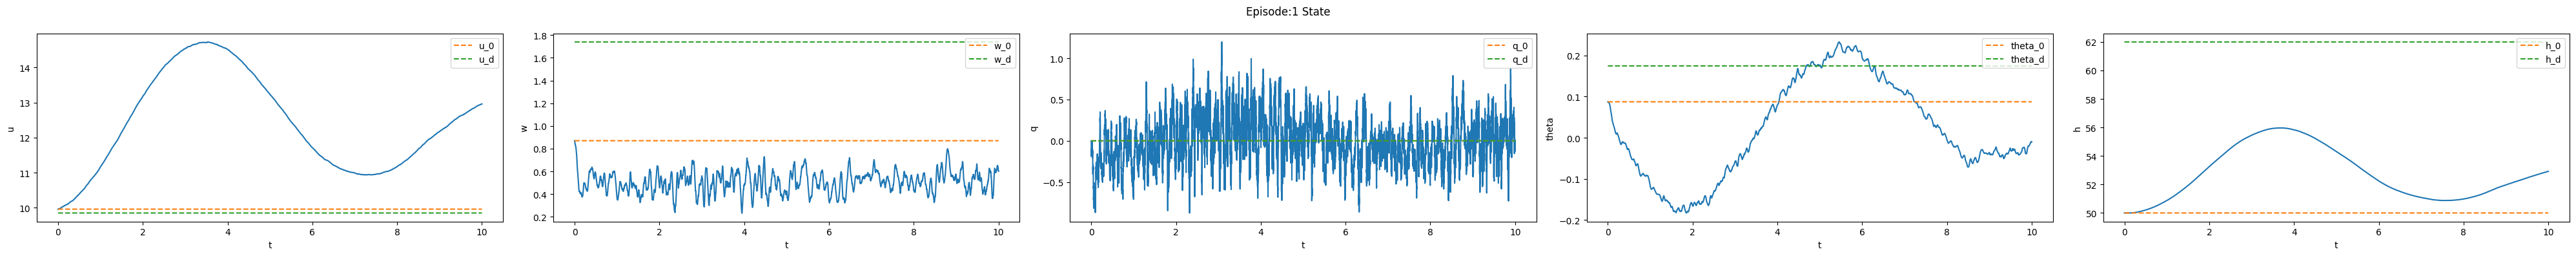

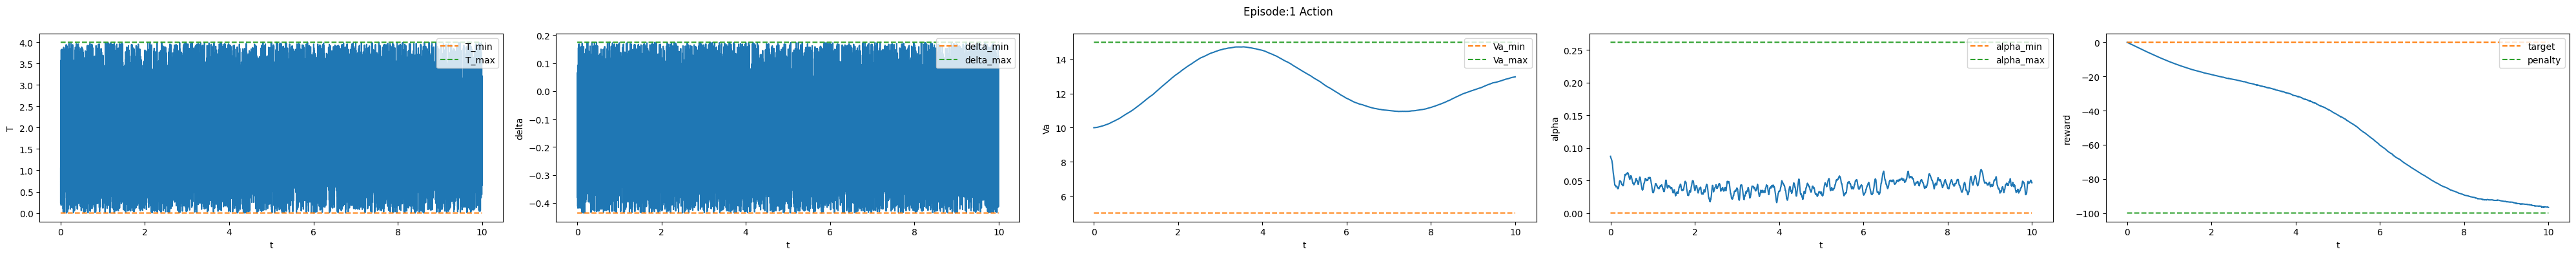

Episode:2 Score:-681998.598819251


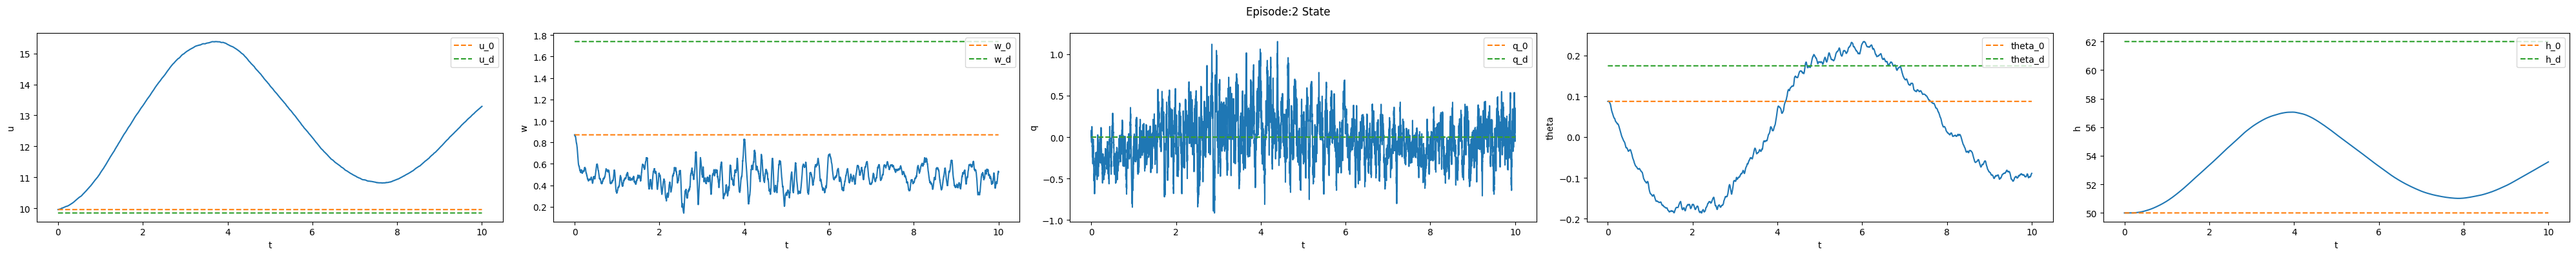

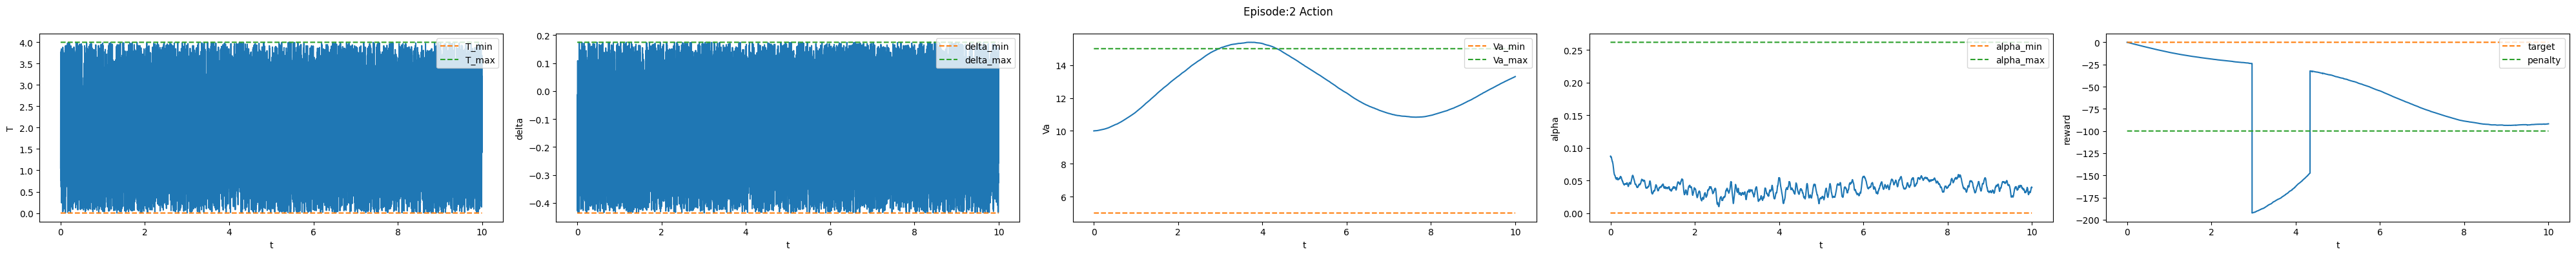

Episode:3 Score:-486294.23682472366


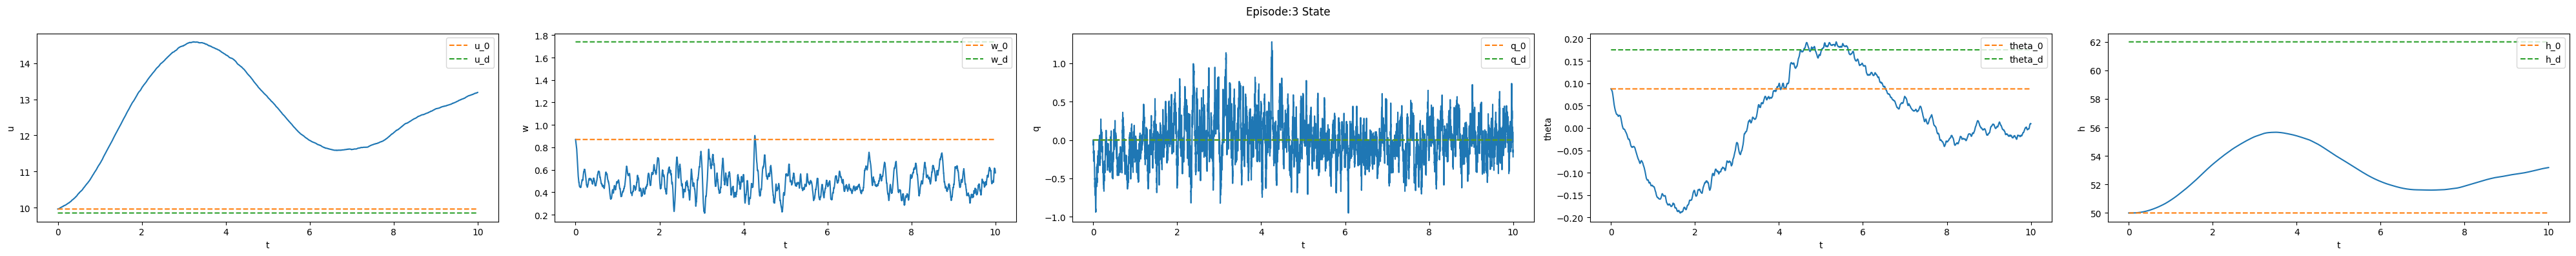

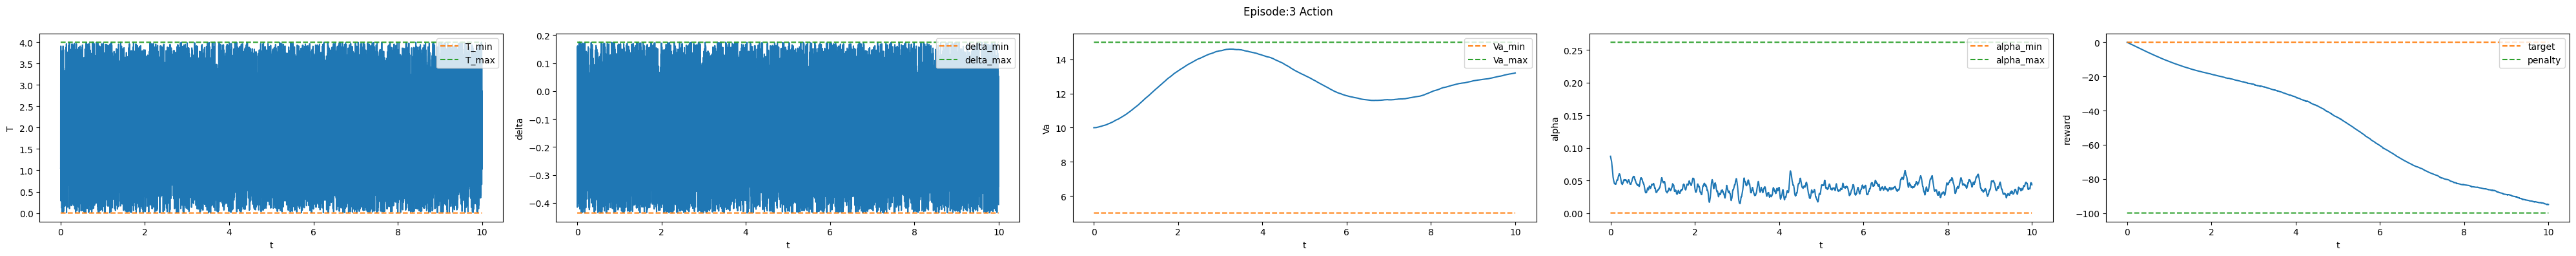

Episode:4 Score:-654763.2972952086


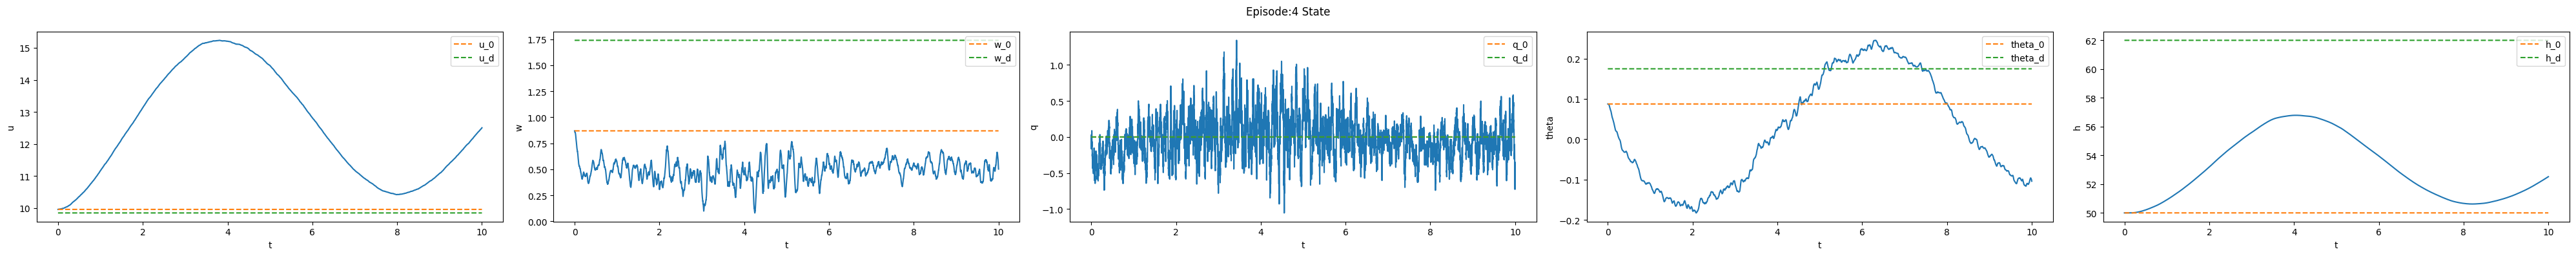

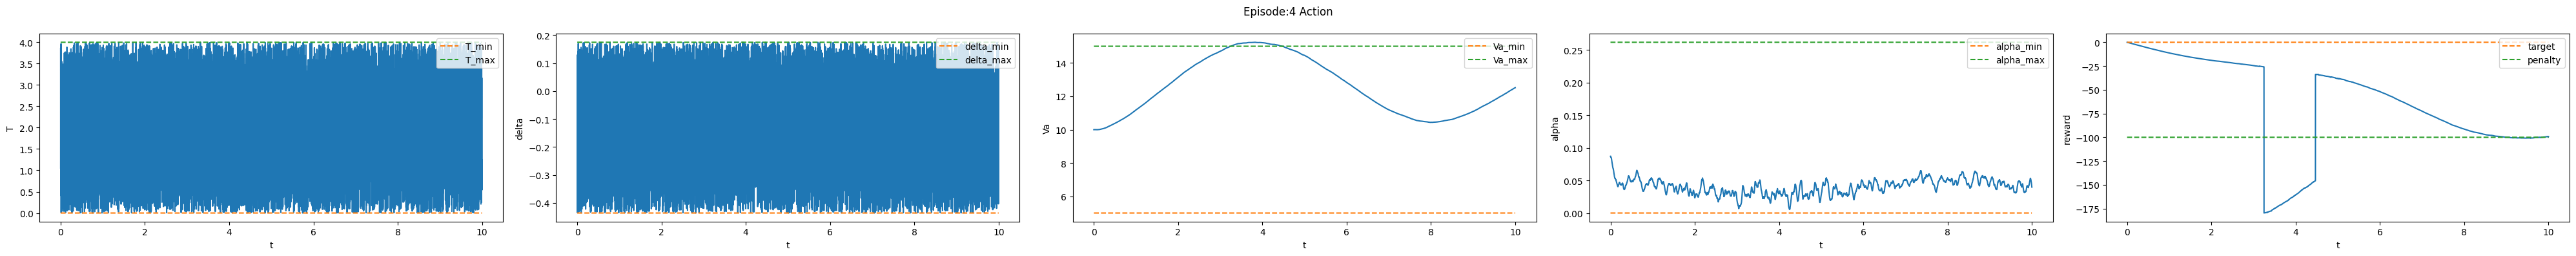

Episode:5 Score:-499083.38716145314


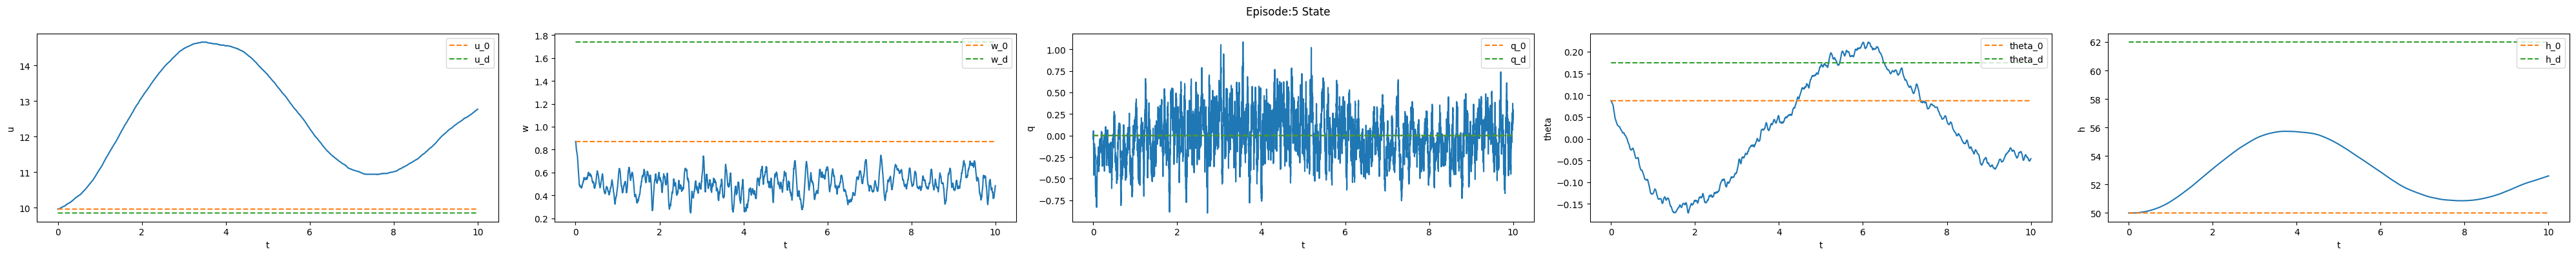

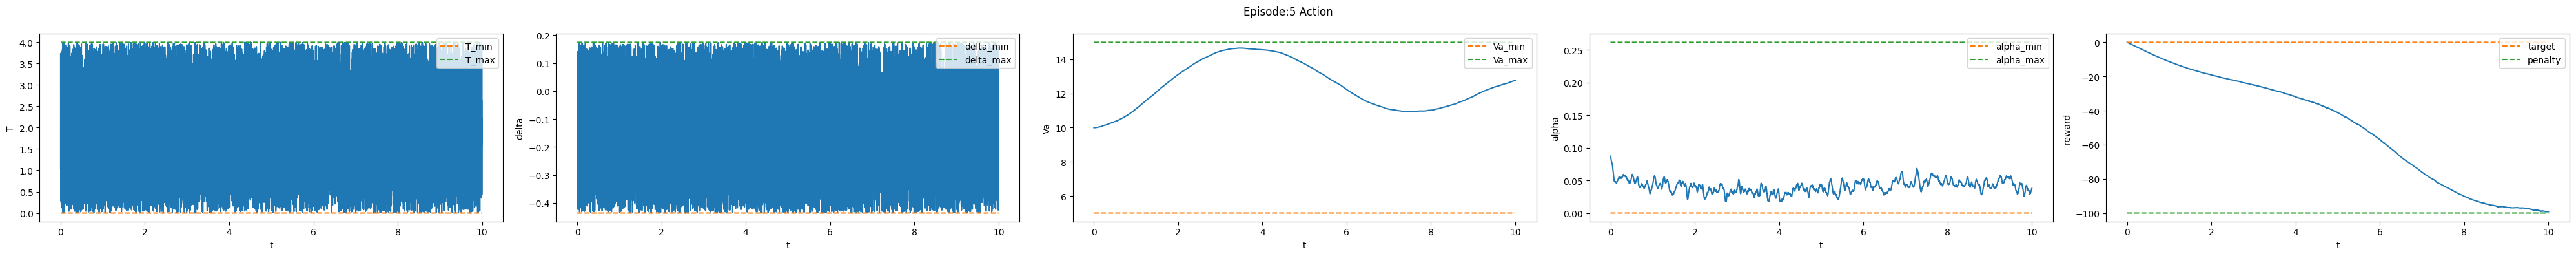

In [4]:
env = UAV_env()
num_episodes = 5

for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    score = 0
    X = []  
    t = []
    U = []
    R = []
    I = []
    while not done:
        if env.t == 0:
            action = env.U0
        else:
            # action = DQN(state)  # Use DQN in keras-rl2 to get our actual action policy
            action = env.action_space.sample() # Random action to test environment
        U.append(env.transform(action))
        t.append(env.t)
        X.append([state[0], state[1], state[2], state[3], state[4]])
        state, reward, done, _, info = env.step(action)
        score += reward
        R.append(reward)
        I.append([info['Va'], info['alpha']])
        
    print('Episode:{} Score:{}'.format(episode+1, score))
    plot(env, X, U, I, R, t, episode)
    
env.close()

# Agent Setup

In [5]:
from stable_baselines3 import DQN, PPO, DDPG, SAC
from stable_baselines3.common.env_checker import check_env

In [6]:
# Register UAV environment
gym.register('UAV-disc', entry_point=UAV_env, kwargs={'action': 'discrete', 'terminate': True})
env_disc = gym.make('UAV-disc')
check_env(env_disc)

gym.register('UAV-box', entry_point=UAV_env, kwargs={'action': 'box', 'terminate': True})
env_box = gym.make('UAV-box')
check_env(env_box)

# PPO stable baseline

In [7]:
# model = PPO("MlpPolicy", env_box, verbose=1)
# model.learn(total_timesteps=10000)
# vec_env = model.get_env()

# num_episodes = 1000

# for episode in range(num_episodes):
#     state = vec_env.reset()
#     done = False
#     score = 0
#     X = []  
#     t = []
#     U = []
#     R = []
#     I = []
#     while not done:
#         action = model.predict(state, deterministic=True)[0]
#         U.append([env_box.transform(action[0])[0], env_box.transform(action[0])[1]])
#         t.append(env_box.t)
#         X.append([state[0][0], state[0][1], state[0][2], state[0][3], state[0][4]])
#         state, reward, done, info = vec_env.step(action)
#         score += reward[0]
#         R.append([reward[0]])
#         I.append([info[0]['Va'], info[0]['alpha']])
        
#     print('Episode:{} Score:{}'.format(episode+1, score))
#     if episode == num_episodes-1:
#         plot(env_box, X, U, I, R, t, episode)

# env_box.close()

# PPO_cont scratch

In [8]:
import argparse
import os, shutil
from datetime import datetime

import wandb
# wandb.login(key='913841cb22c908099db4951c258f4242c1d1b7aa')
os.environ['WANDB_API_KEY'] = '913841cb22c908099db4951c258f4242c1d1b7aa'
os.environ['WANDB_SILENT'] = 'true'

from tqdm import tqdm

import random
import numpy as np
import torch

import gymnasium as gym
from PPO_cont import PPO

In [9]:
config = {
    'dvc': None,
    
    # "env": 'Pendulum-v1',
    "env": 'UAV-box',
    
    # 'render': False,
    'checkpoint': None,
    
    'seed': 0,
    'T_horizon': 2048,
    'Max_train_steps': int(5e7),
    'save_interval': int(1e5),
    'eval_interval': int(5e3),
    'log_interval': int(5e3),

    
    'gamma': 0.99,
    'lambd': 0.95,
    'clip_rate': 0.2,
    'K_epochs': 10,
    'net_width': 150,
    'a_lr': 2e-4,
    'c_lr': 2e-4,
    'l2_reg': 1e-3,
    'a_optim_batch_size': 64,
    'c_optim_batch_size': 64,
    'entropy_coef': 1e-3,
    'entropy_coef_decay': 0.99,
}

In [10]:
from types import SimpleNamespace

args = SimpleNamespace(**config)

if args.dvc is None:
    args.dvc = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

display(args)

namespace(dvc=device(type='cuda'),
          env='UAV-box',
          checkpoint=None,
          seed=0,
          T_horizon=2048,
          Max_train_steps=50000000,
          save_interval=100000,
          eval_interval=5000,
          gamma=0.99,
          lambd=0.95,
          clip_rate=0.2,
          K_epochs=10,
          net_width=150,
          a_lr=0.0002,
          c_lr=0.0002,
          l2_reg=0.001,
          a_optim_batch_size=64,
          c_optim_batch_size=64,
          entropy_coef=0.001,
          entropy_coef_decay=0.99)

In [11]:
def Action_adapter(a,max_action):
	#from [0,1] to [-max,max]
	return  2*(a-0.5)*max_action

def Reward_adapter(r):
	# For BipedalWalker
    # if r <= -100: r = -1

	# For Pendulum-v0
    r = (r + 8) / 8
    return r

In [12]:
def evaluate_policy(env, agent, max_action, turns):
	total_scores = 0
	for j in range(turns):
		s, info = env.reset()
		done = False
		while not done:
			a, logprob_a = agent.select_action(s, deterministic=True) # Take deterministic actions when evaluation
			act = Action_adapter(a, max_action)  # [0,1] to [-max,max]
			s_next, r, dw, tr, info = env.step(act)
			done = (dw or tr)

			total_scores += r
			s = s_next

	return total_scores/turns

In [13]:
def render_environment(env, model, args):
    run = wandb.init(
        project="RL-Project-2",
        name="Evaluation Rendering", 
        config={
            "checkpoint": args.checkpoint,
        }
    )

    try:
        print(f'Render Evaluation -> Env:{args.env}')

        total_steps = 0
        while True:
            reward = evaluate_policy(env, model, args.max_action, turns=1)
            total_steps += 1

            wandb.log({
                "reward": reward,
            })
            
            print(f'Reward Episode - {total_steps}: {reward}')

    except (AssertionError, KeyboardInterrupt) as err:
        print(f'Exiting Render Mode ...')

    finally:
        run.finish()

    return


In [14]:
def _set_reproducable(seed=0):
    print(f'Random Seed: {seed}')

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # safe to call when cuda not available

    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.benchmark = False

    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

## Train

In [15]:
# Build Env
# env = gym.make(args.env, render_mode = "human" if args.render else None)
env = gym.make(args.env)
eval_env = gym.make(args.env)

args.state_dim = env.observation_space.shape[0]
args.action_dim = env.action_space.shape[0]
args.max_action = float(env.action_space.high[0])

# args.max_steps = env._max_episode_steps
args.max_steps = 1000

print('Env:',args.env,'  state_dim:',args.state_dim,'  action_dim:',args.action_dim,
      '  max_a:',args.max_action,'  min_a:',env.action_space.low[0], 'max_steps', args.max_steps)

# Seed Everything
_set_reproducable(args.seed)

if not os.path.exists('./checkpoints'): 
    os.mkdir('./checkpoints')

model = PPO(**vars(args))

if args.checkpoint:
    model.load(args.env, args.checkpoint)

# if args.render:
#     render_environment(env, model, args)

#     env.close()
#     eval_env.close()
#     return

run = wandb.init(
    project="RL-Project-2",
    config=config
)

traj_length, total_steps, train_steps = 0, 0, 0
env_seed = args.seed

try:
    pbar = tqdm(total = args.Max_train_steps)
    while total_steps < args.Max_train_steps:
        s, info = env.reset(seed=env_seed) # Do not use args.seed directly, or it can overfit to args.seed
        env_seed += 1
        done = False
        curr_steps = total_steps

        '''Interact & trian'''
        while not done:
            '''Interact with Env'''
            a, logprob_a = model.select_action(s, deterministic=False) # use stochastic when training
            act = Action_adapter(a, args.max_action) #[0,1] to [-max,max]
            s_next, r, dw, tr, info = env.step(act) # dw: dead&win; tr: truncated
            r = Reward_adapter(r)
            done = (dw or tr)

            wandb.log({
                "Interact/reward": r,
                "Interact/total_steps": total_steps,
            })

            '''Store the current transition'''
            model.put_data(s, a, r, s_next, logprob_a, done, dw, idx = traj_length)
            s = s_next

            traj_length += 1
            total_steps += 1

            '''Update if its time'''
            if traj_length % args.T_horizon == 0:
                train_steps = model.train(total_steps, train_steps)
                traj_length = 0

            '''Record & log'''
            if total_steps % args.eval_interval == 0:
                score = evaluate_policy(eval_env, model, args.max_action, turns=3) # evaluate the policy for 3 times, and get averaged result
                
                print('EnvName:',args.env,'seed:',args.seed,'steps: {}k'.format(int(total_steps/1000)),'score:', score)

                wandb.log({
                    "Eval/reward": score,
                    "Eval/total_steps": total_steps,
                    "Eval/eval_steps": total_steps // args.eval_interval,
                })

            '''Save model'''
            if total_steps % args.save_interval==0:
                model.save(args.env, int(total_steps/1000))

        pbar.update(total_steps - curr_steps)

except (AssertionError, KeyboardInterrupt) as err:
    print(f'Exiting Training ... : {total_steps} steps')

finally:
    pbar.close()
    env.close()
    eval_env.close()
    run.finish()

Env: UAV-box   state_dim: 5   action_dim: 2   max_a: 4.0   min_a: 0.0 max_steps 1000
Random Seed: 0


  0%|          | 3942/50000000 [00:29<32:44:14, 424.22it/s]

EnvName: UAV-box seed: 0 steps: 5k score: -466881.4587786542


  0%|          | 10000/50000000 [01:16<185:27:42, 74.87it/s]

EnvName: UAV-box seed: 0 steps: 10k score: -3946.5527319278376


  0%|          | 14305/50000000 [01:35<38:26:52, 361.14it/s] 

EnvName: UAV-box seed: 0 steps: 15k score: -8521.3965947456


  0%|          | 19973/50000000 [02:05<57:15:33, 242.46it/s]

EnvName: UAV-box seed: 0 steps: 20k score: -4912.328015947715


  0%|          | 24644/50000000 [02:30<112:02:37, 123.90it/s]

EnvName: UAV-box seed: 0 steps: 25k score: -4392.192861997811


  0%|          | 30014/50000000 [02:54<51:34:53, 269.10it/s] 

EnvName: UAV-box seed: 0 steps: 30k score: -280.0257798247525


  0%|          | 34999/50000000 [03:19<148:00:10, 93.78it/s] 

EnvName: UAV-box seed: 0 steps: 35k score: -888.0589319833238


  0%|          | 39919/50000000 [03:40<58:47:11, 236.07it/s] 

EnvName: UAV-box seed: 0 steps: 40k score: -1140.767515949403


  0%|          | 44930/50000000 [04:02<44:14:45, 313.62it/s] 

EnvName: UAV-box seed: 0 steps: 45k score: -1230.0641263761113


  0%|          | 50019/50000000 [04:28<78:28:03, 176.82it/s] 

EnvName: UAV-box seed: 0 steps: 50k score: -631.5611443699045


  0%|          | 54976/50000000 [04:48<36:50:13, 376.62it/s] 

EnvName: UAV-box seed: 0 steps: 55k score: -498.2061145890141


  0%|          | 60058/50000000 [05:12<90:50:37, 152.70it/s] 

EnvName: UAV-box seed: 0 steps: 60k score: -730.0975903840326


  0%|          | 65022/50000000 [05:32<52:27:40, 264.40it/s] 

EnvName: UAV-box seed: 0 steps: 65k score: -563.9602906341073


  0%|          | 70080/50000000 [05:53<61:40:03, 224.91it/s] 

EnvName: UAV-box seed: 0 steps: 70k score: -607.7370499477997


  0%|          | 75017/50000000 [06:11<32:34:04, 425.82it/s] 

EnvName: UAV-box seed: 0 steps: 75k score: -721.7310549061003


  0%|          | 77138/50000000 [06:19<68:13:35, 203.26it/s] 


Exiting Training ... : 77167 steps


## Test

Episode:100 Score:-201.5191301696256
Episode:200 Score:-201.5191301696256
Episode:300 Score:-201.5191301696256
Episode:400 Score:-201.5191301696256
Episode:500 Score:-201.5191301696256
Episode:600 Score:-201.5191301696256
Episode:700 Score:-201.5191301696256
Episode:800 Score:-201.5191301696256
Episode:900 Score:-201.5191301696256
Episode:1000 Score:-201.5191301696256


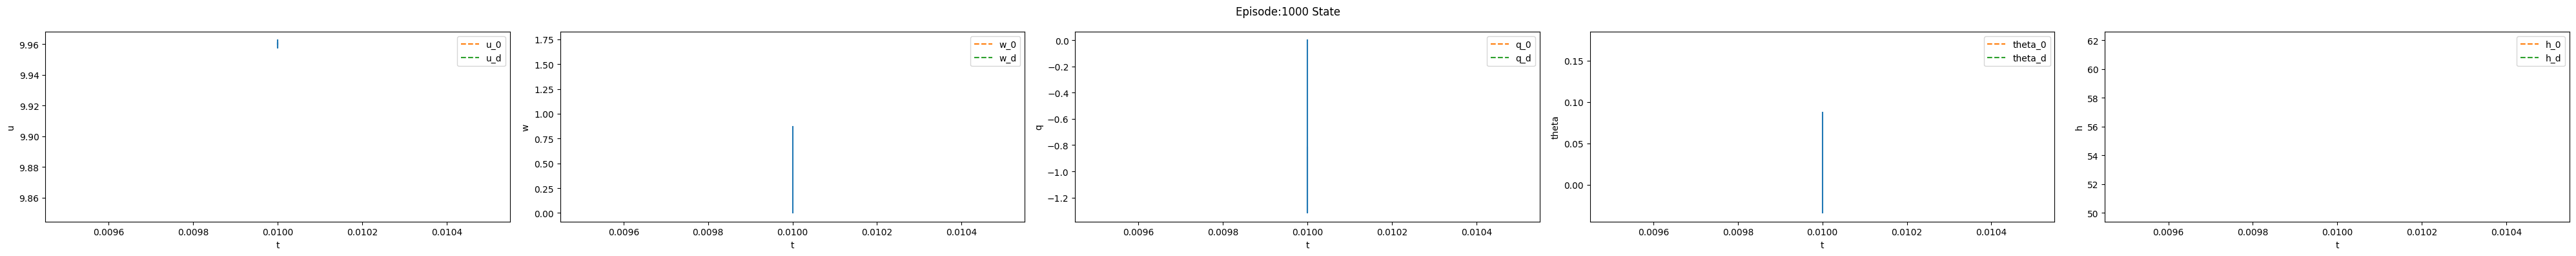

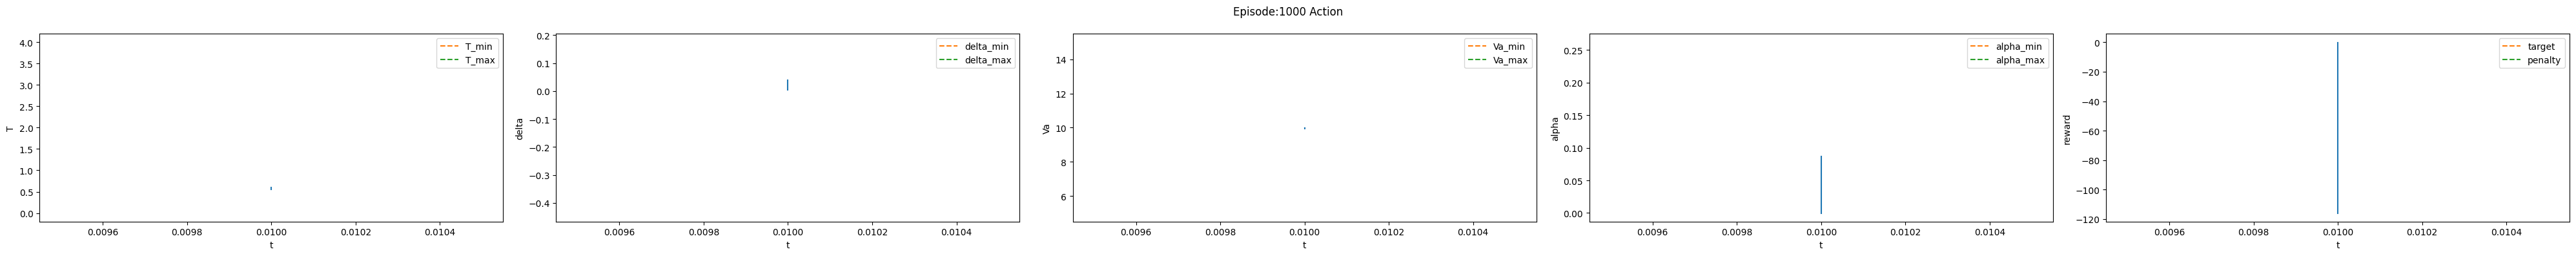

In [16]:
num_episodes = 1000

for episode in range(num_episodes):
    state, info = env.reset()
    
    done = False
    score = 0
    
    X = []  
    t = []
    U = []
    R = []
    I = []
    
    while not done:
        action, action_prob = model.select_action(state, deterministic=True)

        # U.append([env_box.transform(action[0])[0], env_box.transform(action[0])[1]])
        U.append([env_box.transform(action)[0], env_box.transform(action)[1]])
        t.append(env_box.t)
        # X.append([state[0][0], state[0][1], state[0][2], state[0][3], state[0][4]])
        X.append([state[0], state[1], state[2], state[3], state[4]])
            
        # obs, reward, done, info = env.step(action)
        state, reward, done, truncated, info = env.step(action)
        # score += reward[0]
        score += reward
        
        # R.append([reward[0]])
        R.append([reward])
        # I.append([info[0]['Va'], info[0]['alpha']])
        I.append([info['Va'], info['alpha']])

    if (episode + 1) % 100 == 0:
        print('Episode:{} Score:{}'.format(episode+1, score))
    
    if episode == num_episodes-1:
        plot(env_box, X, U, I, R, t, episode)

env_box.close()